# Import packages

In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Utility

In [49]:
import math
def display_imgs(imgs, img_num_per_row, img_size, fig_size):
    """
    A function to show imageS
    
    parameter:
    
    -- imgs: list
           List of images
    -- img_num_per_row: int
           THE number of images per row
    -- img_size: tuple of two ints
           Image size 
    -- fig_size: tuple of two ints
           Figure size
    """

    col_num = math.ceil(len(imgs)/img_num_per_row)
    RGB_img = np.zeros((img_size[0] * col_num, img_size[1] * img_num_per_row, 3), dtype=np.uint8)

    for i, img in enumerate(imgs):            
        RGB_img[img_size[0] * (i//img_num_per_row):img_size[0] * ((i//img_num_per_row) + 1)
                ,img_size[1] * (i%img_num_per_row):img_size[1] * ((i%img_num_per_row) + 1),:] = img

#     RGB_img = np.uint8(RGB_img) 
#     RGB_img = cv2.cvtColor(RGB_img,cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(RGB_img, aspect='auto')
    plt.tight_layout()

# Data loading
Here we create lists of [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not-vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images provided by Udacity. Corrisponding folders contain unzilled archives.

As we can see, there are about the same number of objects of both classes, so, wo do not need to balance number of images.

In [47]:
def read_data(data_path):
    # Read in cars and notcars
    images = glob.glob('..//..//Datasets_collection//Vehicle_detection//*//*//*')
    print ("total image number: " + str(len(images)))
    ravel_img_features = np.concatenate((img_features[0].ravel(), img_features[1].ravel(), img_features[2].ravel()))
    cars = []
    notcars = []
    for img_path in images:
        # Read the image
        image = mpimg.imread(img_path)
        # Augment the dataset with horizontally flipped images
        flip_feature_img = cv2.flip(image, 1) 
        if 'non-vehicles' in img_path:
            notcars.append(image)
            notcars.append(flip_feature_img)
        else:
            cars.append(image)
            cars.append(flip_feature_img)
            
    # Uncomment if you need to reduce the sample size
    # sample_size = 500
    # cars = cars[0:sample_size]
    # notcars = notcars[0:sample_size]
    return cars, notcars

data_path = '..//..//Datasets_collection//Vehicle_detection//*//*//*'
cars, notcars = read_data(data_path)
print("car images: ",len(cars))
print("non-car images: " ,len(notcars))
print ("total image number: ",len(cars)+len(notcars))

total image number: 17760
car images:  17584
non-car images:  17936
total image number:  35520


# Features extraction

Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

In [51]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    """
    This method extracts Histogram of Oriented Gradients (HOG) for a given image.
    To extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) in each full image / video frame, 
    apply skimage.feature.hog() with the flag feature_vec=False, and np.ravel() can unroll the feature vector.
    
    skimage.feature.hog computes a Histogram of Oriented Gradients (HOG)

    (1)(optional) global image normalization
    (2)computing the gradient image in row and col
    (3)computing gradient histograms
    (4)normalizing across blocks
    (5)flattening into a feature vector
    
    HOG example:
        http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
    HOG doc: 
        http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

    * Parameters
    
    -- img: uint8, ndarray
           A 2-D matrix.
           
    -- orient: int
           Number of orientation bins.
           
    -- pix_per_cell: int 
           Size (in pixels) of a cell.
           
    -- cell_per_block: int
           Number of cells in each block.
           
    -- vis: boolean
           If True, the method returns a 2-D matrix of HOG features.
           
    -- feature_vec: boolean
           Flatten the HOG feature matrix to 1-D vector if True, 
           or the output feature array will have a shape of (number_yblocks, number_xblocks, cell_per_block, cell_per_block, orient)
    
    * Returns
    
    -- features: float64, ndarray
           HOG descriptor for the image. Size is orient * (height/pix_per_cell) * (width/pix_per_cell) if cell_per_block is 1.
           
    -- hog_image : float64, ndarray
           A visualisation of the HOG image. Only provided if vis is True.
           
    """
    
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, size=(32, 32), color_space='RGB'):
    """
    This method compresses the image and returns binned color features  
    
    * Parameters
    
    -- img: uint8, ndarray
           A 2-D, 3-D matrix.
           
    -- size: tuple of two int
           The new height and width of compressed image
    
    * Returns
    
    -- features: uint8, 3-D ndarray
           A tensor of color features. A 1-D vector can be extracted with np.ravel() 
    """
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)       

    return cv2.resize(img, size).ravel()


def color_hist(feature_image, nbins=32, color_space='RGB'):
    """
    This method computes color histogram features  
    
    numpy histogram doc:
        https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram.html
    
    * Parameters
    
    -- img: uint8, ndarray
           A 2-D, 3-D matrix.
           
    -- nbins: int or sequence
           If bins is an int, it defines the number of equal-width bins in the given range (10, by default). 
           If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.
    
    * Returns
    
    -- features: int64, 1-D ndarray
           The values of the histogram.
    
    """
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)     
    
    channel1_hist = np.histogram(feature_image[:,:,0], bins=nbins, range=(0, 256))
    channel2_hist = np.histogram(feature_image[:,:,1], bins=nbins, range=(0, 256))
    channel3_hist = np.histogram(feature_image[:,:,2], bins=nbins, range=(0, 256))
    # Concatenate the histograms into a single feature vector
    #We need only the histogram, no bins edges
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Test for `get_hog_features`

In [83]:
img1 = cv2.cvtColor(cars[1000], cv2.COLOR_RGB2GRAY)
hog_feature_1, hog_image_1 = get_hog_features(img1, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_2, hog_image_2 = get_hog_features(img1, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_3, hog_image_3 = get_hog_features(img1, orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_4, hog_image_4 = get_hog_features(img1, orient=9, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_5, hog_image_5 = get_hog_features(img1, orient=8, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
hog_feature_6, hog_image_6 = get_hog_features(img1, orient=9, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
hog_feature_7, hog_image_7 = get_hog_features(img1, orient=8, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
hog_feature_8, hog_image_8 = get_hog_features(img1, orient=9, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
img2 = cv2.cvtColor(notcars[100], cv2.COLOR_RGB2GRAY)
hog_feature_9, hog_image_9 = get_hog_features(img2, orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_10, hog_image_10 = get_hog_features(img2, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_11, hog_image_11 = get_hog_features(img2, orient=8, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_12, hog_image_12 = get_hog_features(img2, orient=9, pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=True)
hog_feature_13, hog_image_13 = get_hog_features(img2, orient=8, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
hog_feature_14, hog_image_14 = get_hog_features(img2, orient=9, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
hog_feature_15, hog_image_15 = get_hog_features(img2, orient=8, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)
hog_feature_16, hog_image_16 = get_hog_features(img2, orient=9, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=True)

(-0.5, 63.5, 63.5, -0.5)

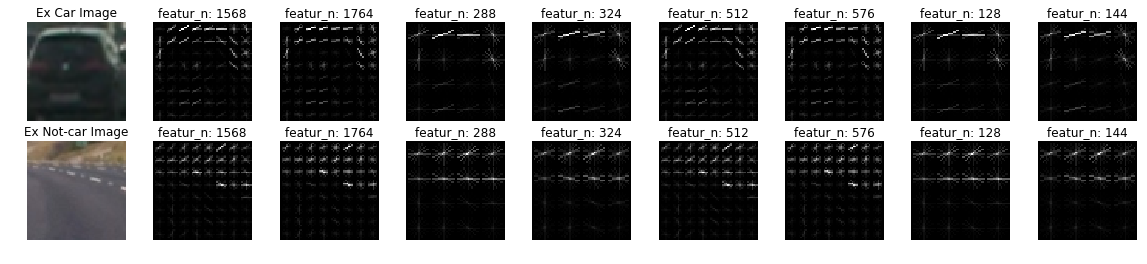

In [84]:
# Plot the examples
fig = plt.figure(figsize=(20,4))
plt.subplot(2,9,1);plt.imshow(cars[1000]);plt.axis('off');plt.title('Ex Car Image')

plt.subplot(2,9,2);plt.imshow(hog_image_1, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_1.shape[0]));plt.axis('off')
plt.subplot(2,9,3);plt.imshow(hog_image_2, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_2.shape[0]));plt.axis('off')
plt.subplot(2,9,4);plt.imshow(hog_image_3, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_3.shape[0]));plt.axis('off')
plt.subplot(2,9,5);plt.imshow(hog_image_4, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_4.shape[0]));plt.axis('off')
plt.subplot(2,9,6);plt.imshow(hog_image_5, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_5.shape[0]));plt.axis('off')
plt.subplot(2,9,7);plt.imshow(hog_image_6, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_6.shape[0]));plt.axis('off')
plt.subplot(2,9,8);plt.imshow(hog_image_7, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_7.shape[0]));plt.axis('off')
plt.subplot(2,9,9);plt.imshow(hog_image_8, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_8.shape[0]));plt.axis('off')

plt.subplot(2,9,10);plt.imshow(notcars[100]);plt.axis('off');plt.title('Ex Not-car Image')
plt.subplot(2,9,11);plt.imshow(hog_image_9, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_9.shape[0]));plt.axis('off')
plt.subplot(2,9,12);plt.imshow(hog_image_10, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_10.shape[0]));plt.axis('off')
plt.subplot(2,9,13);plt.imshow(hog_image_11, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_11.shape[0]));plt.axis('off')
plt.subplot(2,9,14);plt.imshow(hog_image_12, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_12.shape[0]));plt.axis('off')
plt.subplot(2,9,15);plt.imshow(hog_image_13, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_13.shape[0]));plt.axis('off')
plt.subplot(2,9,16);plt.imshow(hog_image_14, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_14.shape[0]));plt.axis('off')
plt.subplot(2,9,17);plt.imshow(hog_image_15, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_15.shape[0]));plt.axis('off')
plt.subplot(2,9,18);plt.imshow(hog_image_16, cmap="gray");plt.title('featur_n: {0}'.format(hog_feature_16.shape[0]));plt.axis('off')

In [4]:
test_img_path = ".//test_images//test1.jpg"
BGR_img = mpimg.imread(test_img_path)
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_img, orient=8, pix_per_cell=16, cell_per_block=1, vis=True, feature_vec=False)

In [5]:
print ("shape of original image",RGB_img.shape)

shape of original image (720, 1280, 3)


shape of HOG features (45, 80, 1, 1, 8)
number of HOG features (28800,)


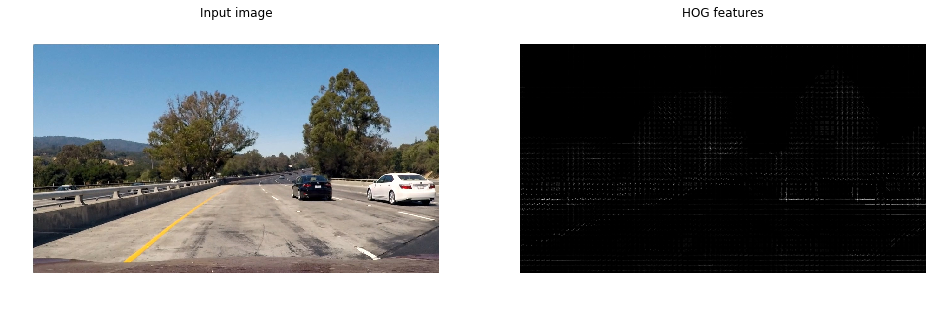

In [6]:
from skimage import exposure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharex=True, sharey=True)

# original image
ax1.axis('off')
ax1.imshow(RGB_img, cmap=plt.cm.gray)
ax1.set_title('Input image')

print ("shape of HOG features",hog_features.shape)
print ("number of HOG features",hog_features.ravel().shape)

# image of HOG features
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG features')

plt.show()

## Test for bin_spatial

shape of spatial features (768,)


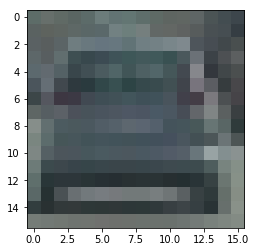

In [46]:
test_img_path = ".//test_images//image0004.png"
car_img = mpimg.imread(test_img_path)

# image of spatial features
bin_spatial_hist = bin_spatial(car_img, size=(16, 16))
print ("shape of spatial features",bin_spatial_hist.shape)
plt.imshow(bin_spatial_hist.reshape(16, 16, 3))

## Test for color_hist

shape of color features (96,)


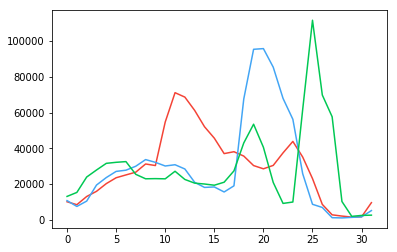

In [14]:
# image of color features
color_hist_feature = color_hist(RGB_img, nbins=32)
print ("shape of color features",color_hist_feature.shape)
plt.plot(color_hist_feature[:32], color="#F44336") # the sum will be the height * width * 3
plt.plot(color_hist_feature[32:64], color="#42A5F5")
plt.plot(color_hist_feature[64:96], color="#00C853")

The `get_img_features` function extracl HOG, color histogram, binned spatial features from images.

In [15]:
def get_img_features(img
                    , hist_bins
                    , orient, pix_per_cell, cell_per_block, hog_channel, spatial_size
                    , color_space='RGB'
                    , spatial_feat = True, hist_feat = True, hog_feat = True):
    """
    This method extracts features from a image
    
    * parameter:
    
    -- img: uint8, ndarray
           A 2-D, 3-D matrix.
           
    -- spatial_feat: boolean
           extract spatial features if True
           Parameter for spatial feature.
           
    -- hist_feat: boolean
           extract color histogram features if True
           
    -- hog_feat: boolean
           extract HOG features if True
           Parameter for HOG feature.
           Parameter for color histogram feature.
           
    -- hist_bins: int or sequence
           If bins is an int, it defines the number of equal-width bins in the given range (10, by default). 
           If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.
           Parameter for color histogram feature.
           
    -- orient: int
           Number of orientation bins.
           Parameter for HOG feature.
           
    -- pix_per_cell: int 
           Size (in pixels) of a cell.
           Parameter for HOG feature.
           
    -- cell_per_block: int
           Number of cells in each block.
           Parameter for HOG feature.
           
    -- hog_channel: string
           If the input is `ALL`, the method will extract the HOG for each channel(RGB) respectively. 
           Otherwise, it will turn the image to grayscale and extract features.        
           Parameter for HOG feature.

    -- color_space: string
           the color space, default is RGB. 
           Parameter for HOG feature.
        
    -- spatial_size: tuple of two int
           The new height and width of compressed image. 
           Parameter for spatial feature.
        
    * Returns
    
    -- features: list
           A list of extracted features.
    """
    
    feature_img = None
    
    if color_space == 'RGB':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    elif color_space == 'HSV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif color_space == 'HLS':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif color_space == 'LAB':
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    else:
        feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      
    
    features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        features.append(spatial_features)
        
    if hist_feat == True:
        hist_features = color_hist(feature_img, nbins=hist_bins)
        features.append(hist_features)
    
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                channel_feature = get_hog_features(feature_img[:,:,channel], 
                                                    orient, pix_per_cell, cell_per_block, 
                                                    vis=False, feature_vec=False).ravel()
                hog_features.append(channel_feature) 
            hog_features = np.array(hog_features)
        else:
            feature_img = cv2.cvtColor(feature_img, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_img, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=False)

        features.append(hog_features)
    return features

## Test on `get_img_features()`

In [16]:
test_img_path = ".//test_images//test1.jpg"
BGR_img = mpimg.imread(test_img_path)

img_features = get_img_features(img = BGR_img
                                , spatial_feat = True, hist_feat = True, hog_feat = True
                                , hist_bins = 32
                                , spatial_size = (16, 16)
                                , orient = 8 , pix_per_cell = 8, cell_per_block = 1, hog_channel = 'ALL', color_space='RGB')

In [17]:
# img_features[0]: spatial features
# img_features[1]: color histogram features
# img_features[2]: HOG features
ravel_img_features = np.concatenate((img_features[0].ravel(), img_features[1].ravel(), img_features[2].ravel()))

In [18]:
print ('shape of spatial features: ', img_features[0].shape)
print ("range of spatial features: ", np.min(img_features[0]),"~", np.max(img_features[0]))

shape of spatial features:  (768,)
range of spatial features:  1 ~ 255


In [14]:
print ('shape of color histogram features: ', img_features[1].shape)
print ("range of color histogram features", np.min(img_features[1]),"~", np.max(img_features[1]))

shape of color histogram features:  (3, 32)
range of color histogram features 942 ~ 111700


In [15]:
print ('shape of HOG features: ', img_features[2].shape)
print ("range of HOG features", np.min(img_features[2]),"~", np.max(img_features[2]))

shape of HOG features:  (90, 160, 1, 1, 8)
range of HOG features 0.0 ~ 0.971079116678


In [16]:
print ("feature number of an image :", ravel_img_features.shape[0])

feature number of an image : 116064


## Test on car and non-car data

In [20]:
car_features = get_img_features(img = cars[1520]
                                , spatial_feat = True, hist_feat = True, hog_feat = True
                                , hist_bins = 32
                                , spatial_size = (16, 16)
                                , orient = 8 , pix_per_cell = 8, cell_per_block = 1, hog_channel = 0, color_space='RGB')
print ('shape of spatial features: ', car_features[0].shape)
print ("range of spatial features: ", np.min(car_features[0]),"~", np.max(car_features[0]))
print ('shape of color histogram features: ', car_features[1].shape)
print ("range of color histogram features", np.min(car_features[1]),"~", np.max(car_features[1]))
print ('shape of HOG features: ', car_features[2].shape)
print ("range of HOG features", np.min(car_features[2]),"~", np.max(car_features[2]))

ravel_car_features = np.concatenate((car_features[0].ravel(), car_features[1].ravel(), car_features[2].ravel()))
print ("feature number of a car image :", ravel_car_features.shape[0])

shape of spatial features:  (16, 16, 3)
range of spatial features:  35 ~ 202
shape of color histogram features:  (3, 32)
range of color histogram features 0 ~ 574
shape of HOG features:  (8, 8, 1, 1, 8)
range of HOG features 0.0 ~ 0.696373535673
feature number of a car image : 1376


In [21]:
notcar_features = get_img_features(img = notcars[1520]
                                , spatial_feat = True, hist_feat = True, hog_feat = True
                                , hist_bins = 32
                                , spatial_size = (16, 16)
                                , orient = 8 , pix_per_cell = 8, cell_per_block = 1, hog_channel = 0, color_space='RGB')
print ('shape of spatial features: ', notcar_features[0].shape)
print ("range of spatial features: ", np.min(notcar_features[0]),"~", np.max(notcar_features[0]))
print ('shape of color histogram features: ', notcar_features[1].shape)
print ("range of color histogram features", np.min(notcar_features[1]),"~", np.max(notcar_features[1]))
print ('shape of HOG features: ', notcar_features[2].shape)
print ("range of HOG features", np.min(notcar_features[2]),"~", np.max(notcar_features[2]))

ravel_notcar_features = np.concatenate((notcar_features[0].ravel(), notcar_features[1].ravel(), notcar_features[2].ravel()))
print ("feature number of a car image :", ravel_notcar_features.shape[0])

shape of spatial features:  (16, 16, 3)
range of spatial features:  28 ~ 255
shape of color histogram features:  (3, 32)
range of color histogram features 0 ~ 1489
shape of HOG features:  (8, 8, 1, 1, 8)
range of HOG features 0.0 ~ 0.93889318102
feature number of a car image : 1376


# Explore Color Spaces

In [22]:
! python color_space_exploration.py

Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)
Figure(800x800)


In [23]:
def plot3d(pixels, colors_rgb
            , axis_labels=list("RGB")
            , axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')


    return ax  # return Axes3D object for further manipulation

## Test on `plot3d()`

In [24]:
# Read a color image
test_img_path = ".//test_images//test1.jpg"
img = mpimg.imread(test_img_path)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_LAB = cv2.cvtColor(img_small, cv2.COLOR_BGR2LAB)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

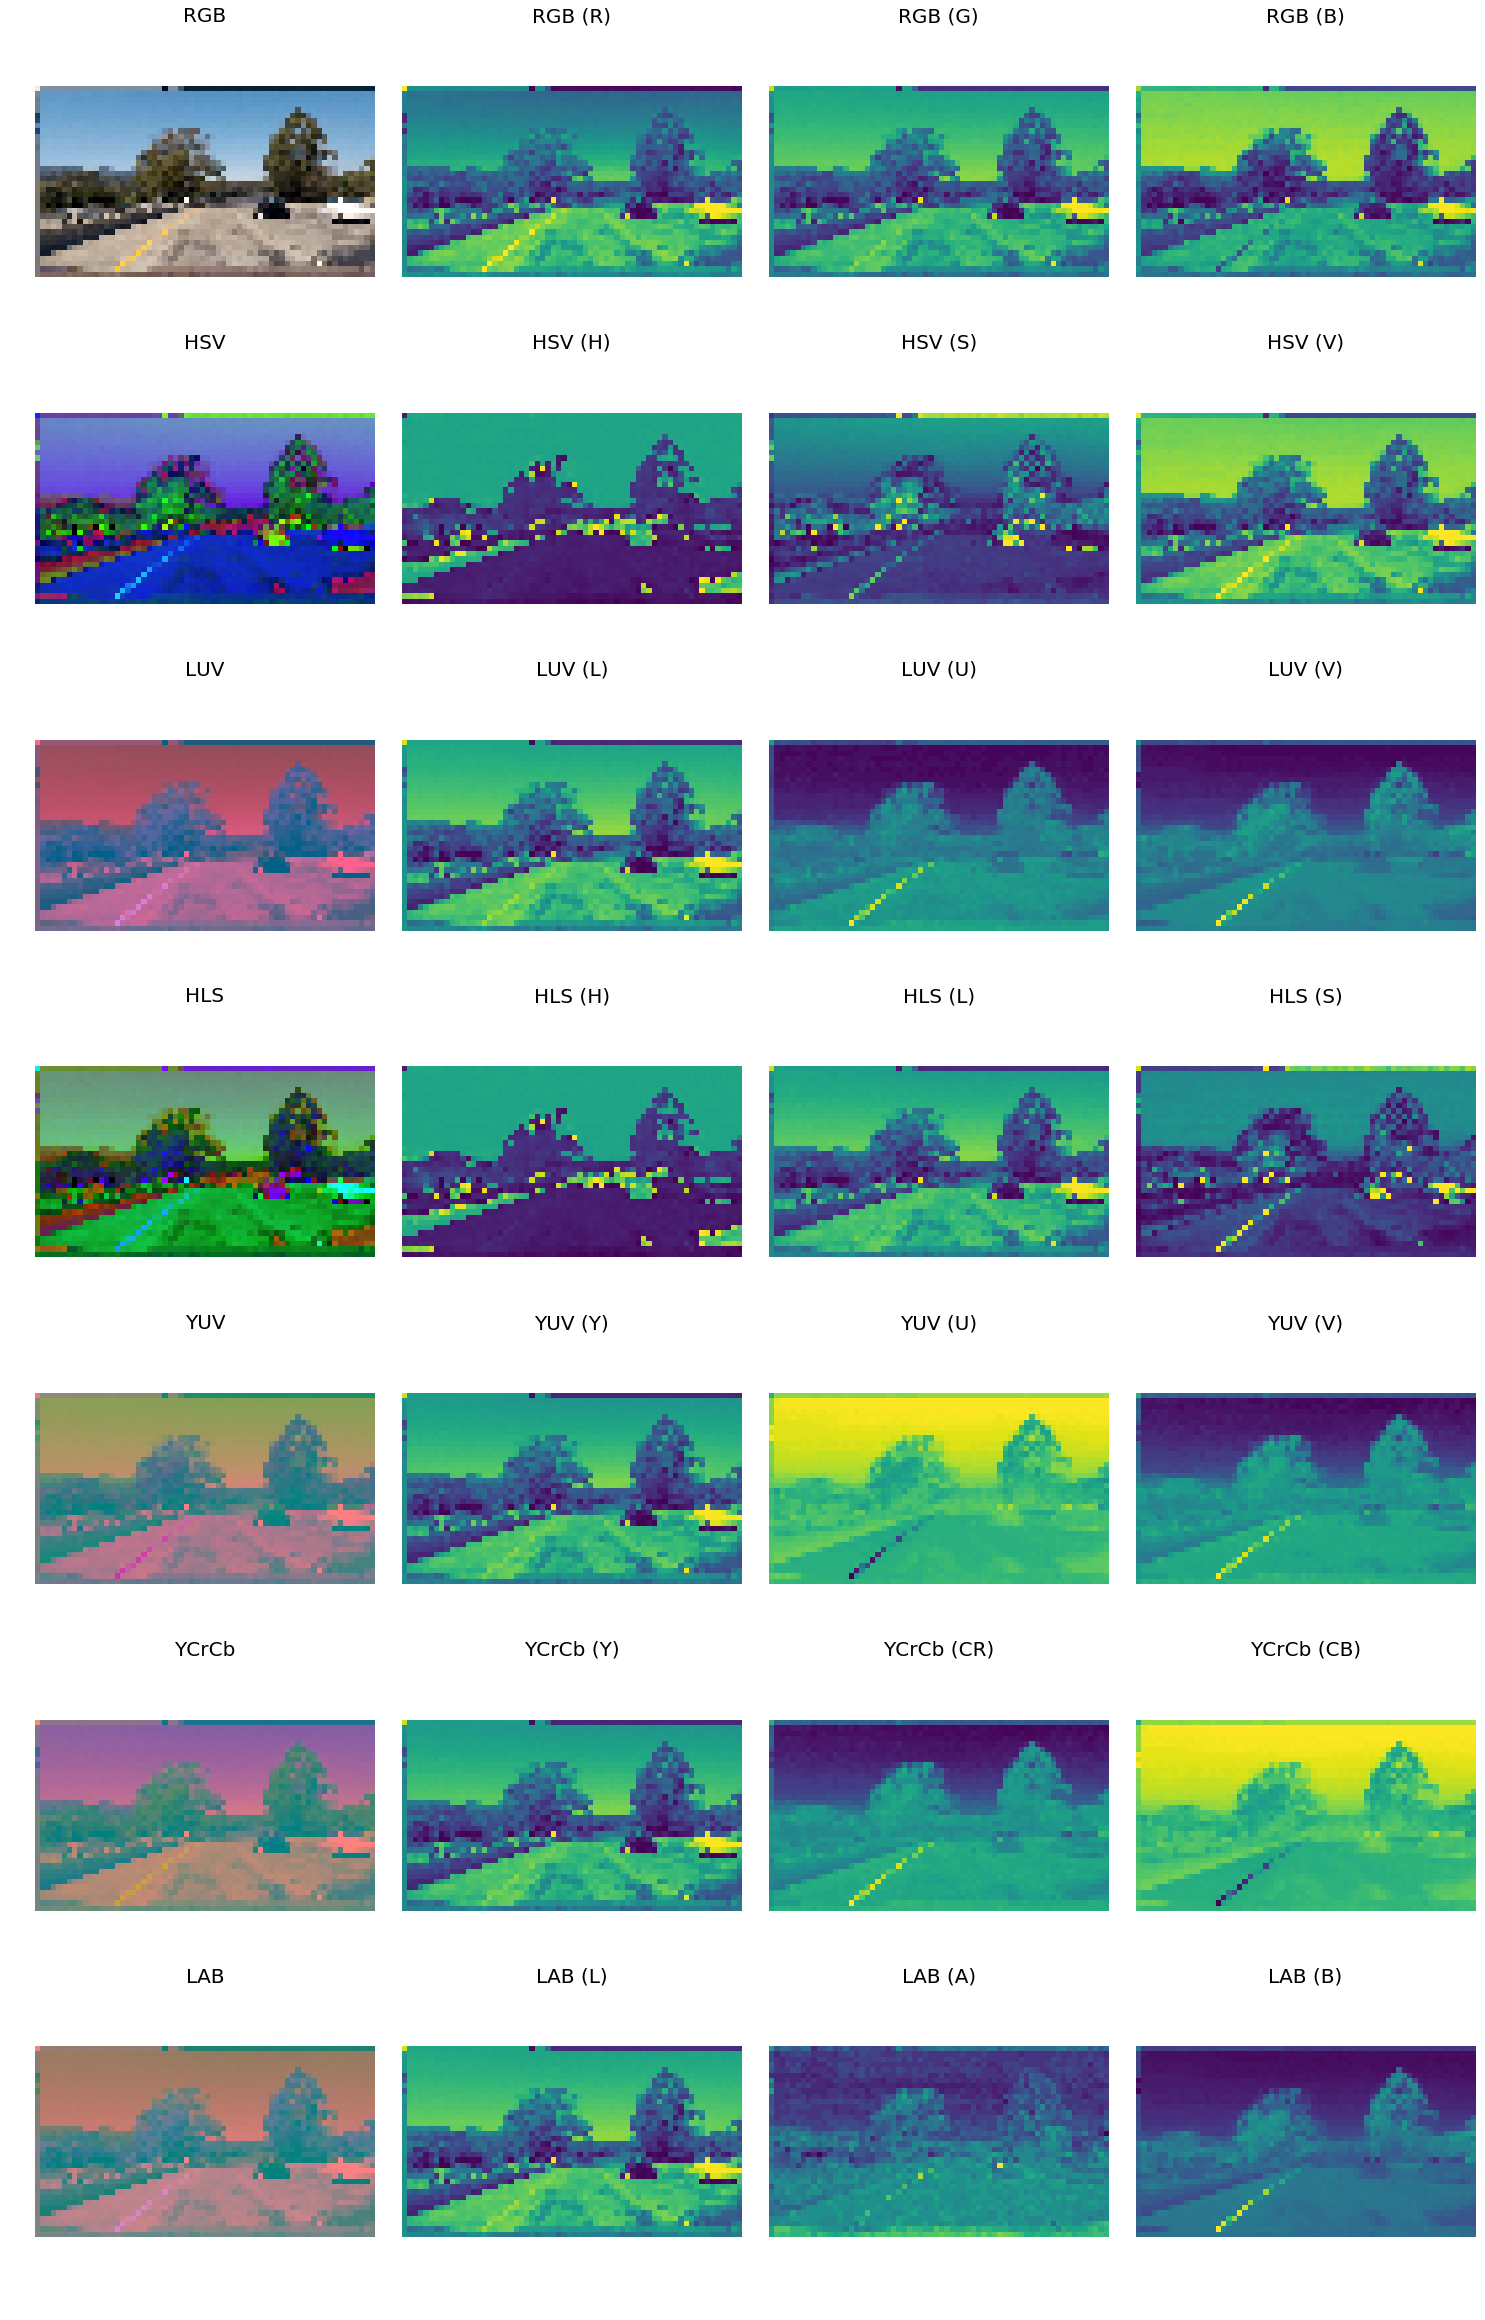

In [25]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8),
    (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16),
   (ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24),
   (ax25, ax26, ax27, ax28)) = plt.subplots(7, 4, figsize=(20, 35), sharex=True, sharey=True)
f.tight_layout()

# RGB
ax1.imshow(img_small_RGB)
ax1.set_title('RGB', fontsize=20)
ax1.axis('off')
ax2.imshow(img_small_RGB[:,:,0])
ax2.set_title('RGB (R)', fontsize=20)
ax2.axis('off')
ax3.imshow(img_small_RGB[:,:,1])
ax3.set_title('RGB (G)', fontsize=20)
ax3.axis('off')
ax4.imshow(img_small_RGB[:,:,2])
ax4.set_title('RGB (B)', fontsize=20)
ax4.axis('off')

# HSV
ax5.imshow(img_small_HSV)
ax5.set_title('HSV', fontsize=20)
ax5.axis('off')
ax6.imshow(img_small_HSV[:,:,0])
ax6.set_title('HSV (H)', fontsize=20)
ax6.axis('off')
ax7.imshow(img_small_HSV[:,:,1])
ax7.set_title('HSV (S)', fontsize=20)
ax7.axis('off')
ax8.imshow(img_small_HSV[:,:,2])
ax8.set_title('HSV (V)', fontsize=20)
ax8.axis('off')

# LUV
ax9.imshow(img_small_LUV)
ax9.set_title('LUV', fontsize=20)
ax9.axis('off')
ax10.imshow(img_small_LUV[:,:,0])
ax10.set_title('LUV (L)', fontsize=20)
ax10.axis('off')
ax11.imshow(img_small_LUV[:,:,1])
ax11.set_title('LUV (U)', fontsize=20)
ax11.axis('off')
ax12.imshow(img_small_LUV[:,:,2])
ax12.set_title('LUV (V)', fontsize=20)
ax12.axis('off')

# HLS
ax13.imshow(img_small_HLS)
ax13.set_title('HLS', fontsize=20)
ax13.axis('off')
ax14.imshow(img_small_HLS[:,:,0])
ax14.set_title('HLS (H)', fontsize=20)
ax14.axis('off')
ax15.imshow(img_small_HLS[:,:,1])
ax15.set_title('HLS (L)', fontsize=20)
ax15.axis('off')
ax16.imshow(img_small_HLS[:,:,2])
ax16.set_title('HLS (S)', fontsize=20)
ax16.axis('off')

# YUV
ax17.imshow(img_small_YUV)
ax17.set_title('YUV', fontsize=20)
ax17.axis('off')
ax18.imshow(img_small_YUV[:,:,0])
ax18.set_title('YUV (Y)', fontsize=20)
ax18.axis('off')
ax19.imshow(img_small_YUV[:,:,1])
ax19.set_title('YUV (U)', fontsize=20)
ax19.axis('off')
ax20.imshow(img_small_YUV[:,:,2])
ax20.set_title('YUV (V)', fontsize=20)
ax20.axis('off')

# YCrCb
ax21.imshow(img_small_YCrCb)
ax21.set_title('YCrCb', fontsize=20)
ax21.axis('off')
ax22.imshow(img_small_YCrCb[:,:,0])
ax22.set_title('YCrCb (Y)', fontsize=20)
ax22.axis('off')
ax23.imshow(img_small_YCrCb[:,:,1])
ax23.set_title('YCrCb (CR)', fontsize=20)
ax23.axis('off')
ax24.imshow(img_small_YCrCb[:,:,2])
ax24.set_title('YCrCb (CB)', fontsize=20)
ax24.axis('off')

# LAB
ax25.imshow(img_small_LAB)
ax25.set_title('LAB', fontsize=20)
ax25.axis('off')
ax26.imshow(img_small_LAB[:,:,0])
ax26.set_title('LAB (L)', fontsize=20)
ax26.axis('off')
ax27.imshow(img_small_LAB[:,:,1])
ax27.set_title('LAB (A)', fontsize=20)
ax27.axis('off')
ax28.imshow(img_small_LAB[:,:,2])
ax28.set_title('LAB (B)', fontsize=20)
ax28.axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

NameError: name 'plot3d' is not defined

In [ ]:
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
plt.show()

plot3d(img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
plt.show()

plot3d(img_small_LAB, img_small_rgb, axis_labels=list("LAB"))
plt.show()

# Data preprocessing

In [145]:
def data_preprocessing(car_data, non_car_data):
    # parameters for feature extraction
    color_space = 'RGB'       # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
    orient = 9                # HOG orientations
    pix_per_cell = 8          # HOG pixels per cell
    cell_per_block = 2        # HOG cells per block
    hog_channel = 0           # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32)   # Spatial binning dimensions
    hist_bins = 32            # Number of histogram bins
    spatial_feat = True       # Spatial features on or off
    hist_feat = True          # Histogram features on or off
    hog_feat = True           # HOG features on or off
    
    # car_data
    car_features = []
    for i in car_data:
        spatial_f, color_hist_f, HOG_f = get_img_features(img = i
                                                    , spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat
                                                    , hist_bins = hist_bins
                                                    , spatial_size = spatial_size
                                                    , orient = orient , pix_per_cell = pix_per_cell, cell_per_block = cell_per_block
                                                    , hog_channel = hog_channel, color_space=color_space)

        car_features.append(np.concatenate((spatial_f.ravel(), color_hist_f.ravel(), HOG_f.ravel())))

    print ('Car samples: ', len(car_features))

    # Non-car data
    non_car_features = []
    for i in non_car_data:
        spatial_f, color_hist_f, HOG_f = get_img_features(img = i
                                                    , spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat
                                                    , hist_bins = hist_bins
                                                    , spatial_size = spatial_size
                                                    , orient = orient , pix_per_cell = pix_per_cell, cell_per_block = cell_per_block
                                                    , hog_channel = hog_channel, color_space=color_space)

        non_car_features.append(np.concatenate((spatial_f.ravel(), color_hist_f.ravel(), HOG_f.ravel())))
    print ('Notcar samples: ', len(notcar_features))
    print('Using:',orient,'orientations', pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    
    return car_features, non_car_features
    

In [146]:
_car_features, _non_car_features = data_preprocessing(cars, notcars)

Car samples:  17584
Notcar samples:  3
Using: 9 orientations 8 pixels per cell and 2 cells per block


# Normalization

In [147]:
def data_normalization(car_features, non_car_features):
    """
    when dealing with image data that was extracted from video
    , you may be dealing with sequences of images where your 
    target object (vehicles in this case) appear almost identical 
    in a whole series of images. 
    
    In such a case, even a randomized train-test split will be 
    subject to overfitting because images in the training set may 
    be nearly identical to images in the test set. 
    
    To optimize your classifier for the project, you may need to worry about time-series of images!
    """
    
    X = np.vstack((car_features, non_car_features)).astype(np.float64)      
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features)))) # Define the labels vector

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    

    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to both X_train and X_test
    scaled_X_train = X_scaler.transform(X_train)
    # It's important to do the scaling after splitting the data, otherwise you are allowing the scaler to peer into your test data!
    scaled_X_test = X_scaler.transform(X_test)

    print('Feature vector length:', len(X_train[0]))  
    return scaled_X_train, scaled_X_test, y_train, y_test, X_scaler

In [148]:
_X_train, _X_test, _y_train, _y_test, feature_scaler = data_normalization(_car_features, _non_car_features)

Feature vector length: 4932


In [149]:
print ("training feature ", _X_train.shape)
print ("training target ", _X_test.shape)
print ("test feature ", _y_train.shape)
print ("test target ", _y_test.shape)
print (feature_scaler)

training feature  (28416, 4932)
training target  (7104, 4932)
test feature  (28416,)
test target  (7104,)
StandardScaler(copy=True, with_mean=True, with_std=True)


In [150]:
print (np.unique(_y_train, return_counts = True))
print (np.unique(_y_test, return_counts = True))

(array([ 0.,  1.]), array([14351, 14065], dtype=int64))
(array([ 0.,  1.]), array([3585, 3519], dtype=int64))


# Train a Classifier

The following code chunk creates feature list for the training data. Feature list is normolized by the `StandardScaler()` method from `sklearn`. The data is splitted into thaining and testing subsets (80% and 20%).


The classifier (Linear SVM) is trained there as well. 

In [151]:
def vehicle_classifier(X_train, X_test, y_train, y_test):
    svc = LinearSVC(C=1.0, loss='hinge') # Use a linear SVC 
    t=time.time() # Check the training time for the SVC
    svc.fit(X_train, y_train) # Train the classifier
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC
    return svc

In [152]:
svc_classifier = vehicle_classifier(_X_train, _X_test, _y_train, _y_test)

27.13 seconds to train SVC...
Test Accuracy of SVC =  0.9841


In [154]:
print('My SVC predicts: ', svc_classifier.predict(_X_test[0:10]))
print('For labels: ', _y_test[0:10])

My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  1.]
For labels:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  1.]


## Save parameter, scaler and classifier

In [144]:
import pickle

In [155]:
dist_pickle = {}
dist_pickle["classifier"] = svc_classifier
dist_pickle["scaler"] = feature_scaler
dist_pickle["orient"] = 9
dist_pickle["pix_per_cell"] = 8
dist_pickle["cell_per_block"] = 2
dist_pickle["spatial_size"] = (32, 32)
dist_pickle["hist_bins"] = 32  

In [157]:
save_path = "saved_file"
file_path = os.path.join(save_path, 'model.p')
with open(file_path, 'wb') as handle:
    pickle.dump(dist_pickle, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Slide window

In [159]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    This method defines a sliding window function. slide_window generates a list of boxes with predefined parameters 
    and a draw_boxes to draw the list of boxes on an image. 

    parameter:
    
    -- img: uint8, ndarray
           A 4-D tensor.
    -- x_start_stop: a list of two int
           The start/stop positions of x for window generation 
    -- y_start_stop: a list of two int
           The start/stop positions of y for window generation 
    -- xy_window: a tuple of two int
           The width and height of a window in pixel
    -- xy_overlap: a tuple of two float
           The overlap rate of two windows for a stride.
           
    * Returns
    
    -- window_list: list
           A list of windows.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to store windows
    window_list = []
    
    # Loop through x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

### test on `slide_window`

In [160]:
test_img_path = ".//test_images//test1.jpg"
img_for_slidingWindow = mpimg.imread(test_img_path)
height, width, _ = img_for_slidingWindow.shape
boxes = slide_window(img_for_slidingWindow, x_start_stop=[0, width], y_start_stop=[0, height], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

In [161]:
boxes[:5]

[((0, 0), (64, 64)),
 ((32, 0), (96, 64)),
 ((64, 0), (128, 64)),
 ((96, 0), (160, 64)),
 ((128, 0), (192, 64))]

In [162]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    This method draw bounding boxes on an image. The bounding boxes are defined in slide_window 

    parameter:
    
    -- img: uint8, ndarray
           A 4-D tensor.
    -- bboxes: list
        A list of boxes.  
    -- color: tuple of three int
           The color of the box edge
    -- thick: int
           The thickness of the box edge
           
    * Returns
    
    -- img: uint8, ndarray
           A image with drawn boxes.
    """
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

### test on `draw_boxes`

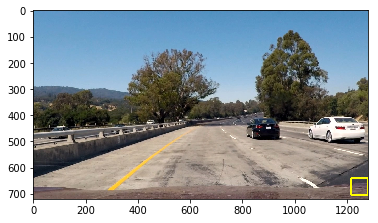

In [74]:
plt.imshow(draw_boxes(cv2.cvtColor(img_for_slidingWindow, cv2.COLOR_BGR2RGB), boxes[-1:], color=(255, 255, 0), thick=6))

In [105]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    This method extracts features from a image based on the list of windows to be searched (output of slide_windows())
    
    parameter:
    
    -- img: uint8, ndarray
           A 2-D, 3-D tensor.
           
    -- clf: classifier object
           predict if the vehicle is in a box
           
    --- scaler: scikit-learn scaler object
           rescale the feature to the range between 0 and 1.
           
    -- windows: list
           List of windows to be searched
             
    * Returns
    
    -- detected_windows: list
           A list of windows which found the target.
    """  
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
                    , (64, 64))      
        #4) Extract features for that window using single_img_features()
        spatial_f, color_hist_f, HOG_f = get_img_features(img = test_img
                                                    , spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat
                                                    , hist_bins = hist_bins
                                                    , spatial_size = spatial_size
                                                    , orient = orient , pix_per_cell = pix_per_cell, cell_per_block = cell_per_block
                                                    , hog_channel = hog_channel, color_space=color_space)

        features = np.concatenate((spatial_f.ravel(), color_hist_f.ravel(), HOG_f.ravel()))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(features.reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [164]:
model_instance = pickle.load( open(file_path, "rb" ) )
model_instance

{'cell_per_block': 2,
 'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
      penalty='l2', random_state=None, tol=0.0001, verbose=0),
 'hist_bins': 32,
 'orient': 9,
 'pix_per_cell': 8,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_size': (32, 32)}

In [165]:
color_space = 'RGB'         # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
orient = 9                  # HOG orientations
pix_per_cell = 8            # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel = 0             # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)     # Spatial binning dimensions
hist_bins = 32              # Number of histogram bins
spatial_feat = True         # Spatial features on or off
hist_feat = True            # Histogram features on or off
hog_feat = True             # HOG features on or off
y_start_stop = (RGB_img.shape[0]//2, RGB_img.shape[0]) # Min and max in y to search in slide_window()

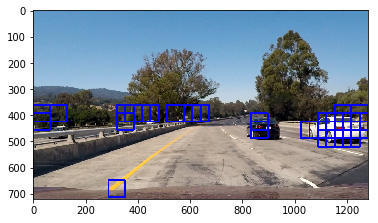

In [166]:
windows = slide_window(RGB_img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))

draw_image = np.copy(RGB_img)

hot_windows = search_windows(RGB_img, windows, svc_classifier, scaler = feature_scaler
                             , color_space=color_space
                             , spatial_size=spatial_size
                             , hist_bins=hist_bins
                             , orient=orient, pix_per_cell=pix_per_cell
                             , cell_per_block=cell_per_block
                             , hog_channel=hog_channel
                             , spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Classifier test

Here we test the calssifier on the test images

In [178]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
#     return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold): # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))

15.1 Seconds to process test images


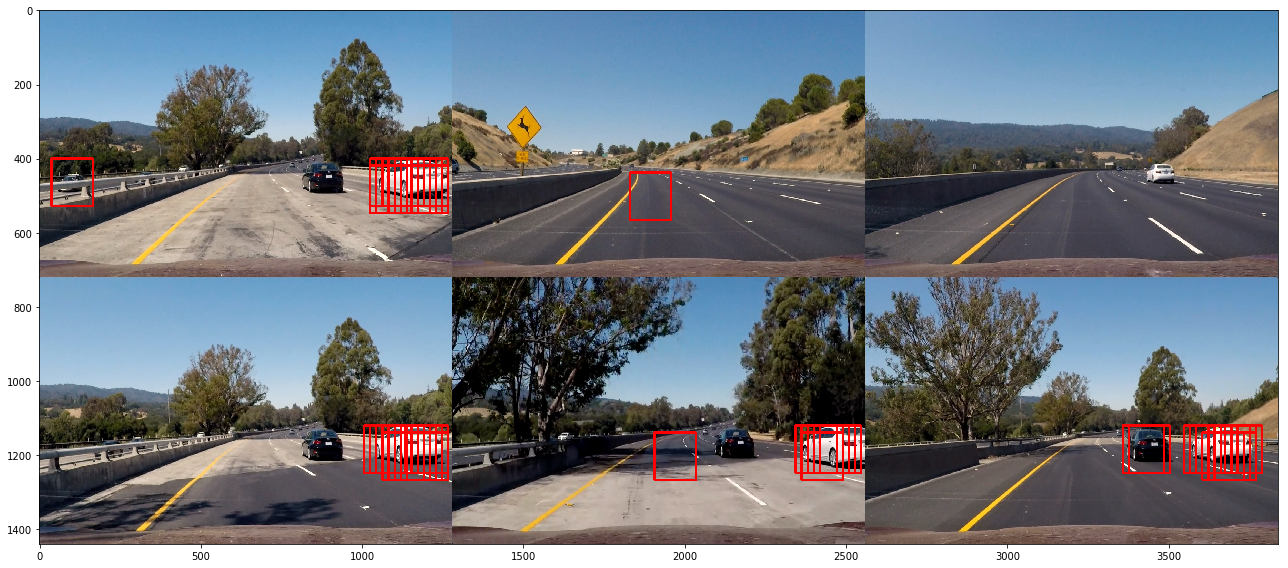

In [181]:
t=time.time() # Start time
window_imgs = []
heat_imgs = []
for image_p in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_p)
    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc_classifier, scaler = feature_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))    
#     print (hot_windows)
    heat = np.zeros_like(img).astype(np.float)
    add_heat(heat, hot_windows)
    heat_imgs.append(heat)
#     heat_l = heat_p + heat
#     heat_p = heat
#     heat_l = apply_threshold(heat_l,THRES) # Apply threshold to help remove false positives
#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat_l, 0, 255)
#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     #print((labels[0]))
#         cars_boxes = draw_labeled_bboxes(labels)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    window_img = cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)
    window_imgs.append(window_img)

display_imgs(window_imgs, img_num_per_row = 3, img_size = (720,1280), fig_size = (18, 8))    

print(round(time.time()-t, 2), 'Seconds to process test images')

As we can see on examples above, the classifier successfully finds cars on the test images. However, there is a false positive example, so, we will need to apply a kind of filter (such as heat map) and the classifier failed to find a car on th 3rd image because it is too small for it. That is why, we will need to use multi scale windows.

In [184]:
import seaborn as sns; sns.set()

In [ ]:
ax = sns.heatmap(heat_imgs[5][:,:,0], annot=True)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Tell pointplot to plot on ax1 with the ax argument
sns.pointplot(x="x", y="y", data=data, ax=ax1)

# Plot the errorbar directly on ax1
ax1.errorbar(np.arange(len(data["x"])), data["y"], yerr=data["s"])

# Tell the factorplot to plot on ax2 with the ax argument
# Also store the FacetGrid in 'g'
g=sns.factorplot(x="x", y="y", data=data, ax=ax2)

# Close the FacetGrid figure which we don't need (g.fig)
plt.close(g.fig)

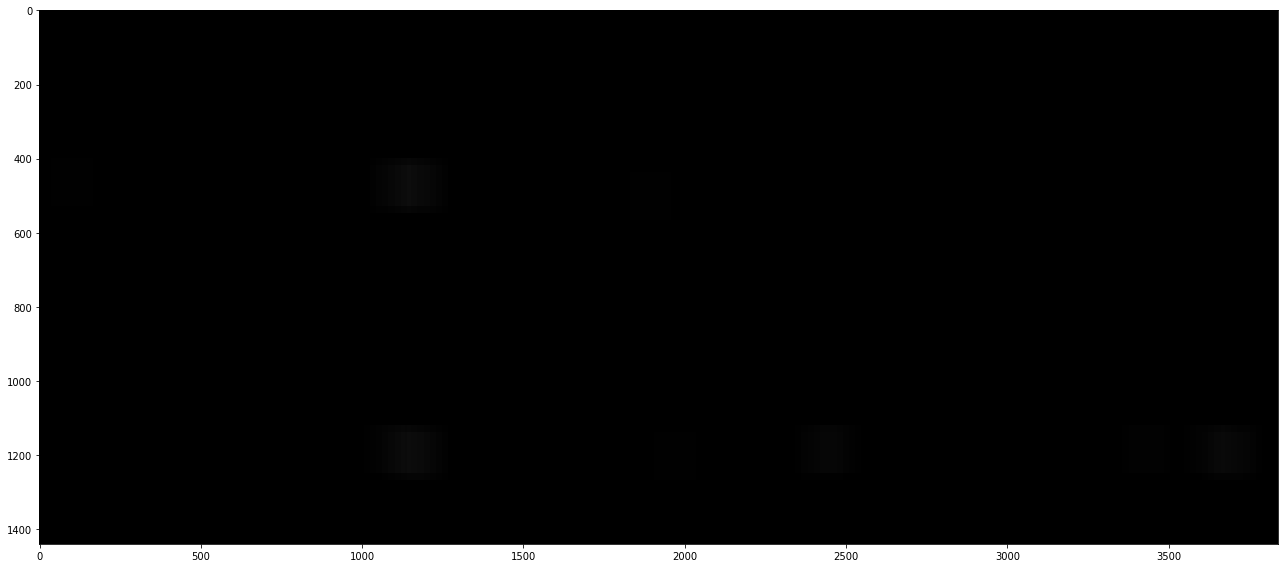

In [182]:
display_imgs(heat_imgs, img_num_per_row = 3, img_size = (720,1280), fig_size = (18, 8)) 

## Advanced Sliding Windows

To increase performance we need to analize the smallest possible number of windows. That is why, we will scan with a search window not across the whole image, but only areas where a new car can appear and also we are going to scan areas where a car was detected (track cars). 

The following code aims at finding windows with a car in a given range with windows of a given scale.

In [ ]:
    """
    A function to show imageS
    
    parameter:
    
    -- img: uint8, ndarray
           List of images
    -- ystart: int
           The y coordinate of starting point to search
    -- ystop: int
           The y coordinate of stopping point to search
    -- xstart: int
           The x coordinate of starting point to search
    -- xstop: int
           The x coordinate of stopping point to search
    -- scale: int
           The scale of the window
    -- step: int
           Figure size
    """
    """
    orient
    cell_per_block
    need to be added
    """

In [168]:
def find_cars(img, ystart, ystop, xstart, xstop, scale, step):
    """
    A function to show imageS
    
    parameter:
    
    -- img: uint8, ndarray
           List of images
    -- ystart: int
           The y coordinate of starting point to search
    -- ystop: int
           The y coordinate of stopping point to search
    -- xstart: int
           The x coordinate of starting point to search
    -- xstop: int
           The x coordinate of stopping point to search
    -- scale: int
           The scale of the window
    -- step: int
           Figure size
    """
    """
    orient
    cell_per_block
    need to be added
    """
    
    boxes = []
    draw_img = np.zeros_like(img)   
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pixel per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return boxes

## Frames processing

Here we process individual images or videos. To increase performance we skip every 2nd frame because we do not expect very fast moving of the detected cars. We filter all found windows by a heatmap approach (with *THRES* threshold), suggested in lectures.

In order to reduce jitter a function `filt` applies a simple low-pass filter on the new and the previous cars boxes coordinates and sizes.

In [154]:
from scipy.ndimage.measurements import label

THRES = 3 # Minimal overlapping boxes
ALPHA = 0.75 # Filter parameter, weight of the previous measurements

image = mpimg.imread('test_images/test1.jpg')
track_list = []#[np.array([880, 440, 76, 76])]
#track_list += [np.array([1200, 480, 124, 124])]
THRES_LEN = 32
Y_MIN = 440

heat_p = np.zeros((720, 1280)) # Store prev heat image
boxes_p = [] # Store prev car boxes
n_count = 0 # Frame counter

* heat-map: 
  (1) combine overlapping detections
  (2) remove false positives

In [156]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold): # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))


def draw_labeled_bboxes(labels):
    global track_list
    track_list_l = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #img = draw_boxes(np.copy(img), [bbox], color=(255,0,255), thick=3)
        size_x = (bbox[1][0]-bbox[0][0])/2.0 #Size of the found box
        size_y = (bbox[1][1]-bbox[0][1])/2.0
        asp_d = size_x / size_y
        size_m = (size_x + size_y)/2
        x = size_x+bbox[0][0]
        y = size_y+bbox[0][1]
        asp = (y-Y_MIN)/130.0+1.2 # Best rectangle aspect ratio for the box (coefficients from perspectieve measurements and experiments)
        if x>1050 or x<230:
            asp*=1.4
        asp = max(asp, asp_d) # for several cars chunk
        size_ya = np.sqrt(size_x*size_y/asp)
        size_xa = int(size_ya*asp)
        size_ya = int(size_ya)
        if x > (-3.049*y+1809): #If the rectangle on the road, coordinates estimated from a test image
            track_list_l.append(np.array([x, y, size_xa, size_ya]))
            if len(track_list) > 0:
                track_l = track_list_l[-1]
                dist = []
                for track in track_list:
                    dist.append(len_points(track, track_l))
                min_d = min(dist)
                if min_d < THRES_LEN:
                    ind = dist.index(min_d)
                    track_list_l[-1] = filt(track_list[ind], track_list_l[-1], ALPHA)
    track_list = track_list_l
    boxes = []
    for track in track_list_l:
        #print(track_to_box(track))
        boxes.append(track_to_box(track))
    return boxes

def frame_proc(img, lane = False, video = False, vis = False):
    global heat_p, boxes_p, n_count
    if (video and n_count%2==0) or not video: # Skip every second video frame
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        boxes = []
        boxes = find_cars(img, 400, 650, 950, 1280, 2.0, 2)
        boxes += find_cars(img, 400, 500, 950, 1280, 1.5, 2)
        boxes += find_cars(img, 400, 650, 0, 330, 2.0, 2)
        boxes += find_cars(img, 400, 500, 0, 330, 1.5, 2)
        boxes += find_cars(img, 400, 460, 330, 950, 0.75, 3)
        for track in track_list:
            y_loc = track[1]+track[3]
            lane_w = (y_loc*2.841-1170.0)/3.0
            if lane_w < 96:
                lane_w = 96
            lane_h = lane_w/1.2
            lane_w = max(lane_w, track[2])
            xs = track[0]-lane_w
            xf = track[0]+lane_w
            if track[1] < Y_MIN:
                track[1] = Y_MIN
            ys = track[1]-lane_h
            yf = track[1]+lane_h
            if xs < 0: xs=0
            if xf > 1280: xf=1280
            if ys < Y_MIN - 40: ys=Y_MIN - 40
            if yf > 720: yf=720
            size_sq = lane_w / (0.015*lane_w+0.3)
            scale = size_sq / 64.0
            # Apply multi scale image windows 
            boxes+=find_cars(img, ys, yf, xs, xf, scale, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.25, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.5, 2)
            boxes+=find_cars(img, ys, yf, xs, xf, scale*1.75, 2)
            if vis:
                cv2.rectangle(img, (int(xs), int(ys)), (int(xf), int(yf)), color=(0,255,0), thickness=3)
        heat = add_heat(heat, boxes)
        heat_l = heat_p + heat
        heat_p = heat
        heat_l = apply_threshold(heat_l,THRES) # Apply threshold to help remove false positives
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_l, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        #print((labels[0]))
        cars_boxes = draw_labeled_bboxes(labels)
        boxes_p = cars_boxes
        
    else:
        cars_boxes = boxes_p
    if lane: #If we was asked to draw the lane line, do it
        if video:
            img = laneline.draw_lane(img, True)
        else:
            img = laneline.draw_lane(img, False)
    imp = draw_boxes(np.copy(img), cars_boxes, color=(0, 0, 255), thick=6)
    if vis:
        imp = draw_boxes(imp, boxes, color=(0, 255, 255), thick=2)
        for track in track_list:
            cv2.circle(imp, (int(track[0]), int(track[1])), 5, color=(255, 0, 255), thickness=4)
    n_count += 1
    return imp

show_img(frame_proc(image, lane=True, vis=False))

ValueError: operands could not be broadcast together with shapes (1,1256) (1376,) (1,1256) 

## Video processing

In [227]:
def draw_line(img, lines, color = (255, 0, 0), thickness = 5):
    """
    Draw a line on image
    
    parameter:
    
    -- img: uint8, ndarray
           A 2-D or 3-D tensor
    -- pts: list of pts
           The starting point and end point of a line: [x1,y1,x2,y2]
    -- color: tuples with three ints
           The color of the line
    -- thickness: int
           The line thickness
    
    return:
    
    -- img: uint8, ndarray
           image with the line
    """
    cp_img = np.copy(img)
    for i in lines:
        cv2.line(cp_img, (i[0], i[1]), (i[2], i[3]), color, thickness)
    return cp_img

In [229]:
test_videos_dir = 'videos//test_input'
test_videos = [os.path.join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]
for test_video in test_videos:
    print('Processing video: {}'.format(test_video))
    cap = cv2.VideoCapture(test_video)  
    
    # get video frame size
    width, height = 0, 0
    if cap.isOpened(): 
        width = int(cap.get(3))
        height = int(cap.get(4)) 

    # initialize video writer object
    out_Video = cv2.VideoWriter(os.path.join('videos//test_output', "processed_" + os.path.basename(test_video)),
                      fourcc=cv2.VideoWriter_fourcc(*'DIVX'),
                      fps=24.0, frameSize=(width, height))
    in_image = None
    try:
        while cap.isOpened():
            # cap.read() returns a bool (True/False). 
            # If frame is read correctly, it will be True. 
            # End of the video can be checked with this return value.
            ret, color_frame = cap.read()
            if ret:
                input_img = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                height, width, _ = input_img.shape
                midLine_img = draw_line(color_frame, lines = [[0, height//2, width, height//2]], color = (255, 0, 0), thickness = 5)       
                out_Video.write(midLine_img)
            else:
                break
        print ("transform ends")        
    finally:
        cap.release()
        out_Video.release()
        cv2.destroyAllWindows()

Processing video: videos//test_input\test_video.mp4
transform ends


----------------
# Test

In [225]:
houghLine_para = { "rho": 1
                , "theta": np.pi/180
                , "threshold": 50
                , "min_line_len": 100
                , "max_line_gap": 160}

rho = houghLine_para["rho"]
theta = houghLine_para["theta"]
threshold = houghLine_para["threshold"]
min_line_len = houghLine_para["min_line_len"]
max_line_gap = houghLine_para["max_line_gap"]
test_img_path = ".//test_images//test1.jpg"
BGR_img = mpimg.imread(test_img_path)
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)

lower_half_img = RGB_img[RGB_img.shape[0]//2:,:,:]

gauss_img = cv2.GaussianBlur(lower_half_img,(7,7),0)  
edges = cv2.Canny(gauss_img, 100, 170, apertureSize = 3)  


hough_lines = np.squeeze(cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap), axis=1)

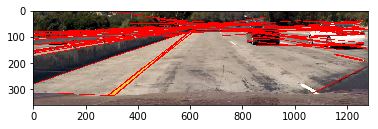

In [226]:
a = draw_line(lower_half_img, hough_lines, color = (255, 0, 0), thickness = 2)
plt.imshow(a)

##### histogram

In [537]:
test_img_path = ".//test_images//test1.jpg"
BGR_img = mpimg.imread(test_img_path)
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)

rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

In [538]:
# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

Text(0.5,1,'B Histogram')

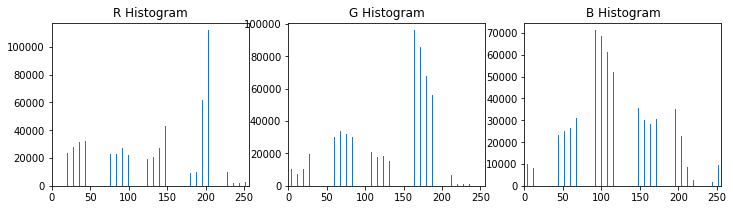

In [539]:
# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

In [540]:
def test_color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

In [550]:
def test_bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size)#.ravel() 
    # Return the feature vector
    return features
    
feature_vec = test_bin_spatial(cars[11], color_space='RGB', size=(32, 32))

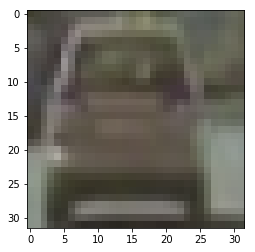

In [551]:
plt.imshow(feature_vec)

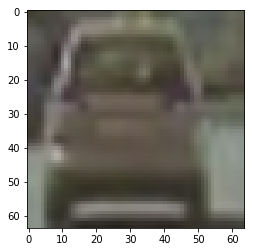

In [552]:
plt.imshow(cars[11])

In [573]:
np_cars = np.array(cars)

In [579]:
np_cars.shape

(17584, 64, 64, 3)

In [577]:
np_cars_reshape = np_cars.reshape(np_cars.shape[0], -1)

In [578]:
np_cars_reshape.shape

(17584, 12288)

In [580]:
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
X_scaler = StandardScaler().fit(np_cars_reshape) # Fit a per-column scaler
X_scaler_np_cars = X_scaler.transform(np_cars_reshape) # Apply the scaler to X

In [597]:
from sklearn.decomposition import PCA 
pca = PCA(2000) 
X_proj = pca.fit_transform(X_scaler_np_cars) 
print (X_proj.shape)

(17584, 2000)


In [598]:
reverse_X = pca.inverse_transform(X_proj)

In [599]:
reverse_scale_X = X_scaler.inverse_transform(reverse_X)

In [600]:
reverse_scale_X[0].shape

(12288,)

In [601]:
test_1car = reverse_scale_X[0].reshape(64,64,3)

Text(0.5,1,'Example Not-car Image')

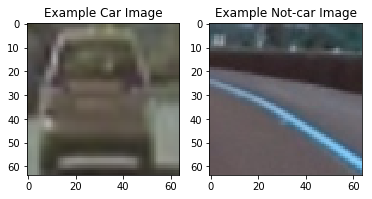

In [42]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(cars[11])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcars[11])
plt.title('Example Not-car Image')

In [43]:
# Random Shuffling of the data

In [ ]:
# Parameter Tuning

In [44]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings." % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 3.03 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.920 (std: 0.010)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 8}

Model with rank: 1
Mean validation score: 0.920 (std: 0.009)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.913 (std: 0.015)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 10}

GridSearchCV took 28.38 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.935 (std: 0.021)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.

In [45]:
a = grid_search.cv_results_  

In [47]:
a['rank_test_score']

array([200, 192, 186, 185, 211, 191, 190, 212, 213, 165, 126, 138, 166,
       120, 135, 146, 131, 146, 117, 124, 111, 160, 155, 141, 159, 157,
       145,  42,  58,  78,  92,  93,  94, 108, 102, 124,  48,  40,  39,
        62,  57,  53,  86,  84,  87,  25,  15,  31,  15,  26,  31,  82,
        82,  74, 210, 169, 188, 182, 198, 209, 214, 208, 204, 128, 127,
       113, 166, 137, 176, 136, 166, 158, 130, 123, 109, 174, 134, 112,
       119, 122, 146,  74,  51,  89, 101,  91,  96, 107, 105, 104,  52,
        45,  53,  74,  24,  46,  80,  69,  88,   4,   3,  34,  42,  21,
        38,  69,  60,  48, 200, 144, 184, 203, 197, 187, 193, 216, 215,
       110, 113, 150, 118, 139, 115, 140, 143, 163, 131, 172, 155, 146,
       133, 152, 179, 169, 152,  66,  34,  41,  69,  62,  79, 100, 103,
        97,  10,  10,  34,  13,  34,  18,  68,  73,  74,   2,   8,  10,
        14,  26,  21,  55,  62,  62, 204, 204, 188, 193, 207, 199, 202,
       196, 195, 173, 150, 128, 116, 174, 120, 106, 160, 163, 15

In [50]:
np.flatnonzero(a['rank_test_score'] == 200)

array([  0, 108], dtype=int64)

In [52]:
import time

In [53]:
def vehicle_classifier(X_train, X_test, y_train, y_test):
    svc = LinearSVC(loss='hinge') # Use a linear SVC 
    t=time.time() # Check the training time for the SVC
    svc.fit(X_train, y_train) # Train the classifier
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC
    return svc
svc_classifier = vehicle_classifier(_X_train, _X_test, _y_train, _y_test)

7.66 seconds to train SVC...
Test Accuracy of SVC =  0.9841


In [59]:
from sklearn.svm import SVC
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]}]

svc = SVC()

clf = GridSearchCV(svc, tuned_parameters)
clf.fit(_X_train, _y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = _y_test, clf.predict(_X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.982 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
0.982 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.982 (+/-0.001) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
0.982 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



NameError: name 'classification_report' is not defined

### Search window test

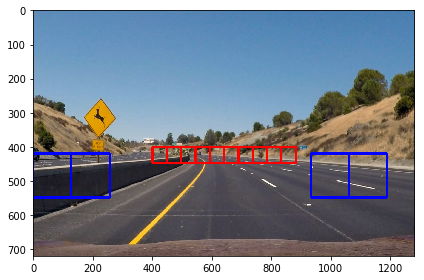

In [142]:
image = mpimg.imread('test_images/test2.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
draw_image = np.copy(image)

xy_overlap_ratio = (0, 0)

windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=xy_overlap_ratio)

windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=xy_overlap_ratio)

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 

windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=xy_overlap_ratio)

window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)  

display_imgs([window_img], img_num_per_row = 1, img_size = (720,1280), fig_size = (6, 4))    

In [176]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            print (np.hstack((spatial_features.ravel(), hist_features.ravel(), hog_features)).shape)
            
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features.ravel(), hist_features.ravel(), hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

# LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0)
# StandardScaler(copy=True, with_mean=True, with_std=True)

# print (svc)
# print (X_scaler)
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32
X_scaler = pick_test["scaler"]
img = mpimg.imread('test_images/test2.jpg')
svc = pick_test["classifier"]

ystart = 400
ystop = 656
scale = 1
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

(8460,)


ValueError: operands could not be broadcast together with shapes (1,8460) (4932,) (1,8460) 

In [158]:
pick_test = pickle.load( open(file_path, "rb" ) )
pick_test

{'cell_per_block': 2,
 'classifier': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
      penalty='l2', random_state=None, tol=0.0001, verbose=0),
 'hist_bins': 32,
 'orient': 9,
 'pix_per_cell': 8,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'spatial_size': (32, 32)}

In [ ]:
image = mpimg.imread('test_images/test5.jpg')
track = (880, 450)
w_size = 80

windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=4)

windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size],
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=4) 
                  
show_img(window_img)